# Visualisation Autocorrelation (Stars-Stars)

### Numerical integration

We work in the Galactic coordinates $(l,b)$, which means to consider the Sun as the origin of spherical coordinates $(\theta, \phi)$. This means the angle $b$ is related to the co-latitude $\theta$ (for the representation with Mollview) as $\theta = \pi/2 -b$, whereas the latitute remains the same as $l$.

In [1]:
import numpy as np
import healpy as hp
import itertools
import jax.numpy as jnp
from jax import vmap, grad
from response import pairwise_monopole, pairwise_dipole, vvec, trace_pair_pair_H0, trace_pair_pair_H1
from jax import config
# config.update("jax_enable_x64", True)

# plot settings
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

font = {'size'   : 18, 'family':'Latin Modern Roman'}
axislabelfontsize='large'

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Monopole

We consider:
* $n = (\theta,\phi)=(\pi/2 ,0)$
* $q$ are stars in each of the pixels defined fot the map. Is called **stars_vec**.

In [2]:
## This part is doing test with the functions to be able to plot them as a scalar function afterwards

get_vec = lambda theta,phi: jnp.array([jnp.sin(theta)*jnp.cos(phi),jnp.sin(theta)*jnp.sin(phi),jnp.cos(theta)])

pi_3 = np.pi/3
pi_4 = np.pi/4
n1 = get_vec(pi_3,pi_3)
n2 = get_vec(pi_4,pi_4)

nside = 32
npix = hp.nside2npix(nside)
pix = np.arange(npix)
print(n1.shape,pix.shape)

pvec_array = np.array(hp.pix2vec(nside,pix)).T

print(np.shape(pvec_array))

monopole = pairwise_monopole(n1,n2,pvec_array,nside)

print(monopole.shape)

print(monopole)

print(jnp.trace(monopole))

(3,) (12288,)
(12288, 3)
(3, 3)
[[ 1.3277693  -0.6614911  -0.47112978]
 [-0.38783485  0.9871325  -0.42376754]
 [-0.56812966 -0.907831    1.0436618 ]]
3.3585637


In [3]:
nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)

theta, phi = (np.pi/2,0)
n1 = get_vec(theta,phi)

stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T

print(stars_vec.shape)

# Trace of H0*H0

#f = lambda q: jnp.trace(pairwise_monopole(n1,q,pvec_array,nside))
f = lambda q: trace_pair_pair_H0(n1,q,pvec_array,nside)
map_stars_H0H0 = vmap(f)(stars_vec)

print(map_stars_H0H0.shape)

# Another way to calculate Trace of H0*H0
f = lambda q: jnp.trace(jnp.square(pairwise_monopole(n1,q,pvec_array,nside)))
map_stars_sq = vmap(f)(stars_vec)

print(map_stars_sq.shape)

(768, 3)
(768,)
(768,)


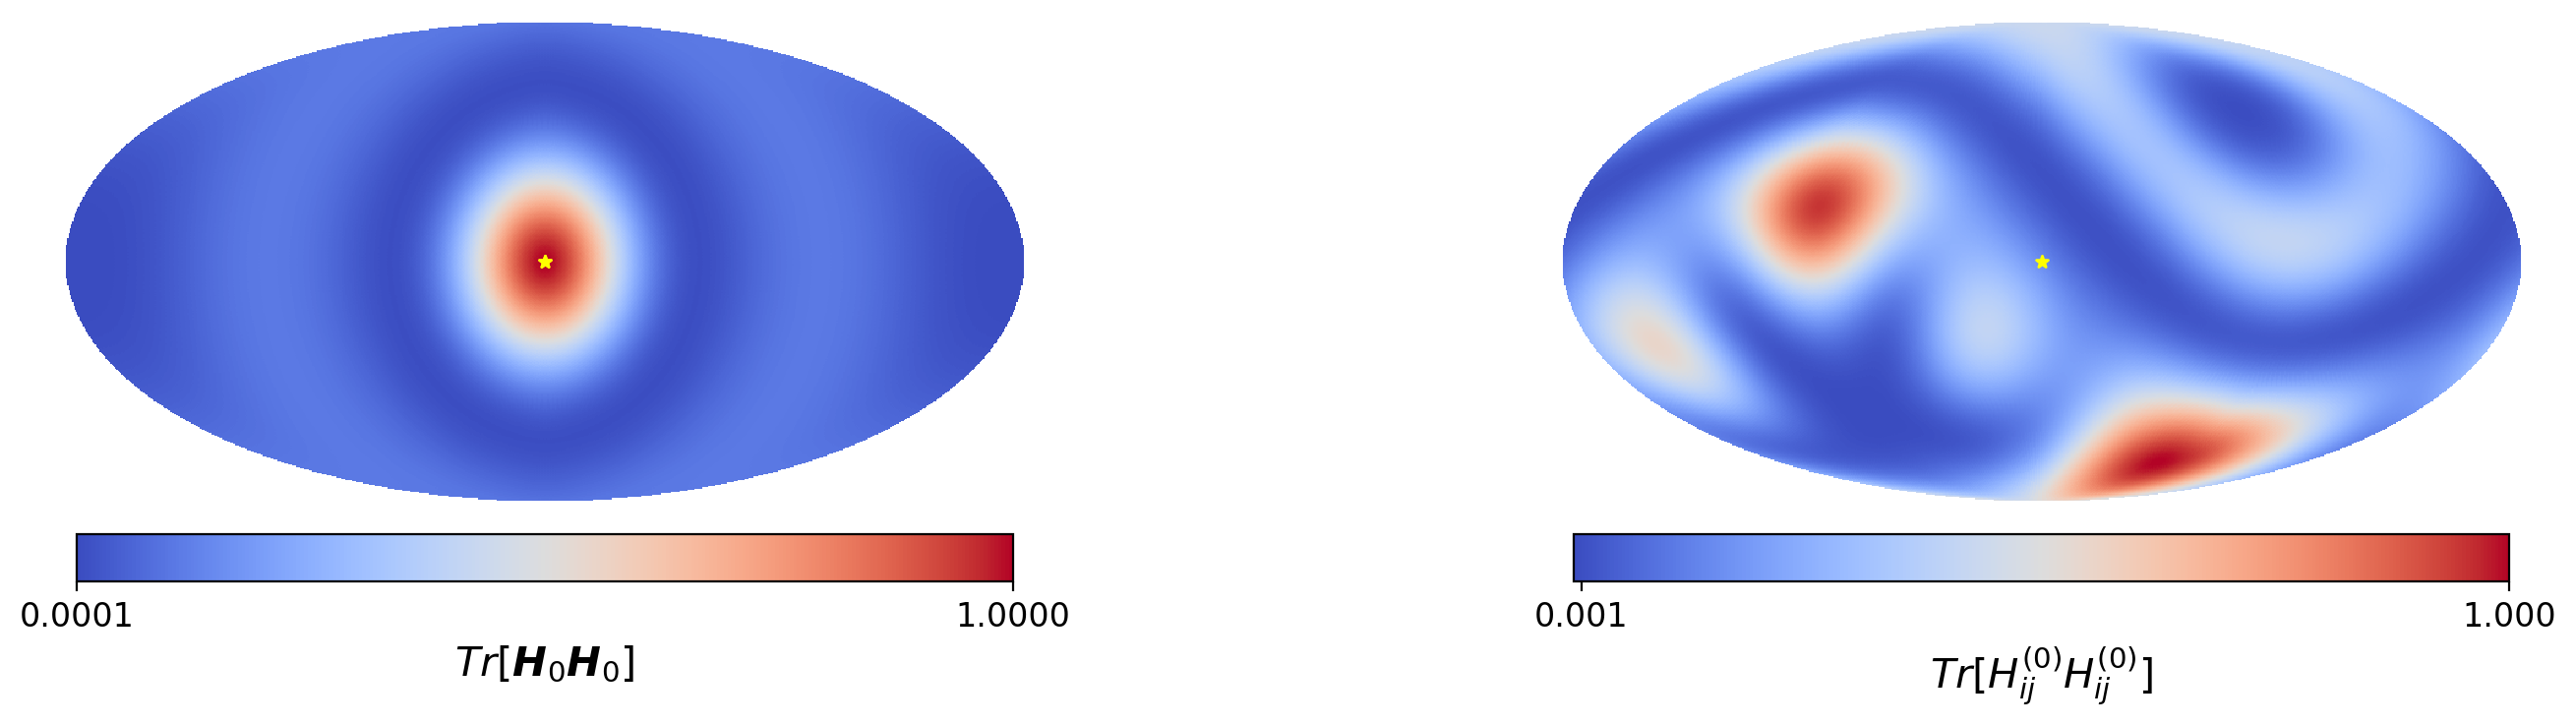

In [9]:

fig, (ax1,ax3) = plt.subplots(1,2,figsize=(18,4))

cmap = 'coolwarm'#'RdBu_r'

fwhm = 0.2

# Trace of H0*H0
sm = map_stars_H0H0
up_map = hp.ud_grade(map_stars_H0H0,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax1)
hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta,phi,marker='*',color='yellow',s=20)
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$Tr[\boldsymbol{H}_0 \boldsymbol{H}_0]$',size=15)


# Another way to calculate Trace of H0*H0
sm = map_stars_sq
up_map = hp.ud_grade(map_stars_sq,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax3)
hp.mollview(sm,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta,phi,marker='*',color='yellow',s=20)
f = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$Tr[H^{(0)}_{ij}H^{(0)}_{ij}]$',size=15)

plt.savefig('monopole.pdf',bbox_inches='tight')

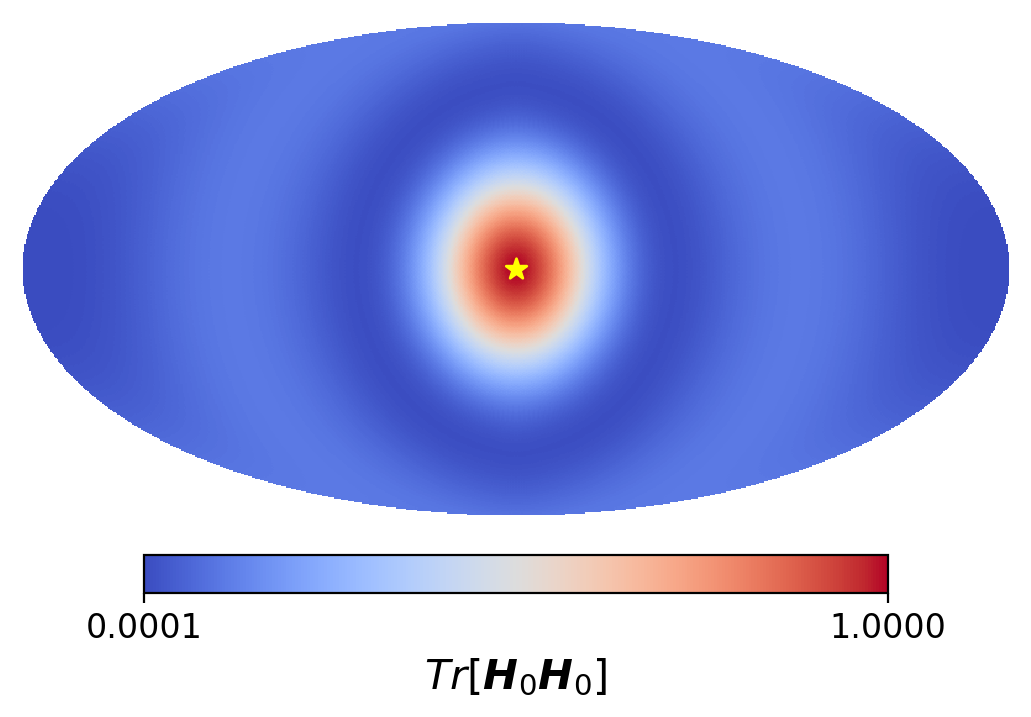

In [12]:
cmap = 'coolwarm'#'RdBu_r'

fwhm = 0.2

# delta_ij H_ij
sm = map_stars_H0H0
up_map = hp.ud_grade(map_stars_H0H0,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
#plt.axes(ax1)
hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta,phi,marker='*',color='yellow',s=60)
#hp.graticule()
f = plt.gcf()


ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$Tr[\boldsymbol{H}_0 \boldsymbol{H}_0]$',size=15)

plt.savefig('TraceH0H0_monopole.pdf',bbox_inches='tight')

# Dipole visualisation
We consider:
* $v = (l,b)= (264^{\circ},48^{\circ})$. The file **response.py** contains the direction of the velocity in **spherical coordinates** with the co-latitude $\theta \in [0,\pi]$ (North pole to South pole),  and the longitude $\phi \in [0, 2\pi]$ eastward. For the projection, $\phi = 0$ is at the center and increases eastward towards the left of the map.
* $n = (l,b)=(0^{\circ},0^{\circ})$ for the first case, and $n=v$ for the second.
* $q$ is the direction of stars in each of the pixels defined on the map. Is called **stars_vec** in the code.

In [23]:
nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)

thetaVvec, phiVvec = hp.vec2ang(vvec)

theta, phi = (np.pi/2,0)
#n1 = get_vec(theta,phi) # Star at the center of the map
#n1 = jnp.array([0.96388439, -0.26566278, 0.01871302]) # Random position in the Sky (close to the centre)
n1 = jnp.array([9.61440915e-04, -2.51119328e-01, -9.67955659e-01]) # Random position in the Sky (south pole)
#n1 = -vvec # Opposite to V
#n1= jnp.array([-0.18639486, -0.72313051, -0.66508587]) # Orthogonal to V
theta_n1, phi_n1 = hp.vec2ang(n1)


l, b = hp.vec2ang(n1, lonlat=True)
print('Coordinate of n1:', l, b)

stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T

print(stars_vec.shape)

# The position of the star n1 is fixed at the centre of the map.

#f = lambda q: jnp.trace(pairwise_dipole(n1,q,pvec_array,nside))
f = lambda q: trace_pair_pair_H1(n1,q,pvec_array,nside)
map_stars_H1H1_center = vmap(f)(stars_vec)
print(map_stars_H1H1_center.shape)


# The next lines are for the case: qi nj H_ij

theta0 = np.pi/2 - np.deg2rad(48)
phi0 = np.deg2rad(264)
n1 = get_vec(theta0,phi0)

#f = lambda q: jnp.trace(pairwise_dipole(n1,q,pvec_array,nside)) # For the Trace of Hij
f = lambda q: jnp.einsum("i...,j...,ij...->...",q,n1,pairwise_dipole(n1,q,pvec_array,nside))
map_stars_dij_v = vmap(f)(stars_vec)

print(map_stars_dij_v.shape)


f = lambda q: jnp.trace(jnp.square(pairwise_dipole(n1,q,pvec_array,nside)))
map_stars_sq = vmap(f)(stars_vec)

print(map_stars_sq.shape)



Coordinate of n1: [270.21936] [-75.456116]
(768, 3)
(768,)
(768,)
(768,)


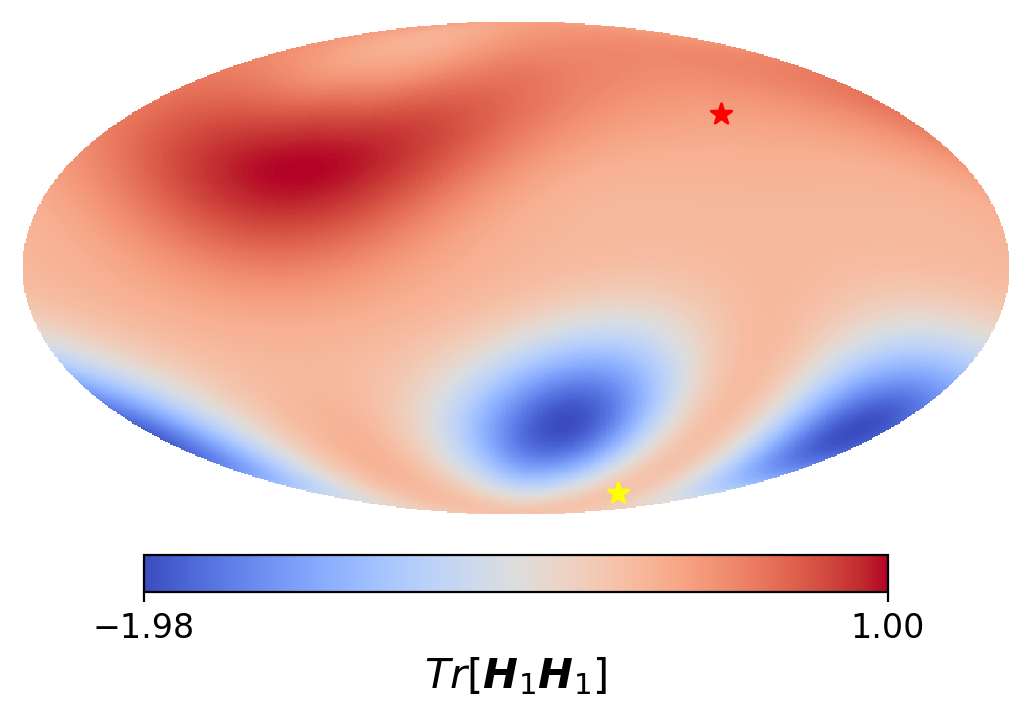

In [24]:
# delta_ij H_ij center
sm = map_stars_H1H1_center
up_map = hp.ud_grade(map_stars_H1H1_center,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)

hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta_n1, phi_n1,color='yellow',s=60, marker='*')
hp.projscatter(thetaVvec, phiVvec,color='red',s=60, marker='*')
#hp.graticule(color="gray")
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$Tr[\boldsymbol{H}_1 \boldsymbol{H}_1]$',size=15)

#plt.savefig('TraceH1H1_dipole.pdf',bbox_inches='tight')
#plt.savefig('TraceH1H1_dipole_centre.pdf',bbox_inches='tight')
plt.savefig('TraceH1H1_dipole_Random.pdf',bbox_inches='tight')

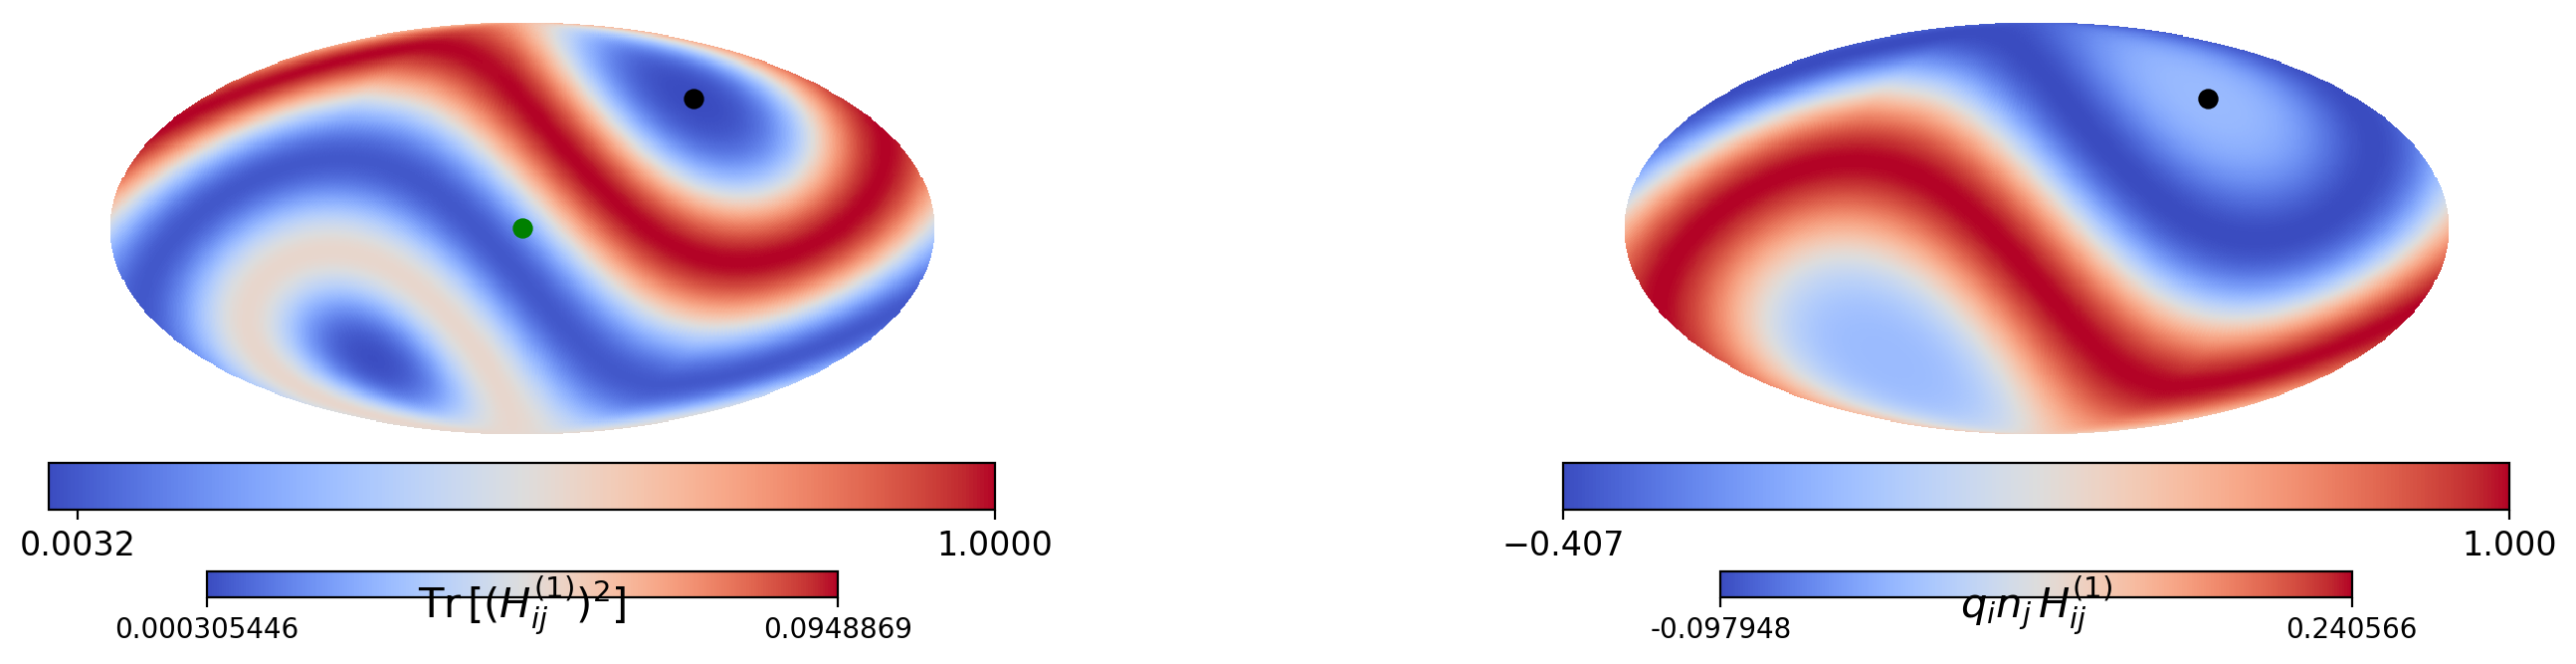

In [8]:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,4))

cmap = 'coolwarm'#'RdBu_r'

fwhm = 0.2

# delta_ij H_ij center
sm = map_stars_H1H1_center
up_map = hp.ud_grade(map_stars_H1H1_center,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax1)
hp.mollview(sm,cmap=cmap,cbar=True,title="",hold=True)
# plt.scatter(0,np.pi/4,color='yellow',s=20)
hp.projscatter(theta,phi,color='green',s=40)
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$\mathrm{Tr}\,[(H^{(1)}_{ij})^2]$',size=15)

# delta_ij H_ij vcmb
sm = map_stars_dij_v
up_map = hp.ud_grade(map_stars_dij_v,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax2)
hp.mollview(sm,cmap=cmap,cbar=True,title="",hold=True)
hp.projscatter(theta0,phi0,color='k',s=40)
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$q_i n_j\,H^{(1)}_{ij}$',size=15)


plt.savefig('dipole.pdf',bbox_inches='tight')